# 05 Analyse

> Analyse metadata from publications.

In [ ]:
#|default_exp core.05_analyse

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#|hide
from nbdev.showdoc import show_doc

In [ ]:
#|export
import pubcrawler as proj
from pubcrawler import const, log, utils, tools
import adu_proj.utils as adutils

In [ ]:
from collections import Counter
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import re
import itertools
import networkx as nx
from pyvis.network import Network
import shutil

In [ ]:
#| echo: false
fm.fontManager.addfont('../fonts/JosefinSans-Regular.ttf')
plt.style.use('../style/autonomy_white.mplstyle')
pd.set_option('display.max_colwidth', None)

In [ ]:
#|export
plots_dir = f'{const.pre_output_path}/plots'
os.makedirs(plots_dir, exist_ok=True)

In [ ]:
pubs = pd.read_csv(f"{const.pre_output_path}/pub_metadata.csv")

Filter for publications containing the org name in the list of organisations:

In [ ]:
org_pubs = pubs[pubs['organisation'].str.contains('|'.join(const.org_names), na=False, case=False)].reset_index(drop=True)

## Author Frequency

We can begin by analysing which authors appear most across all publications.

In [ ]:
authors = [item for sublist in org_pubs['authors'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
author_frequency = Counter(authors)

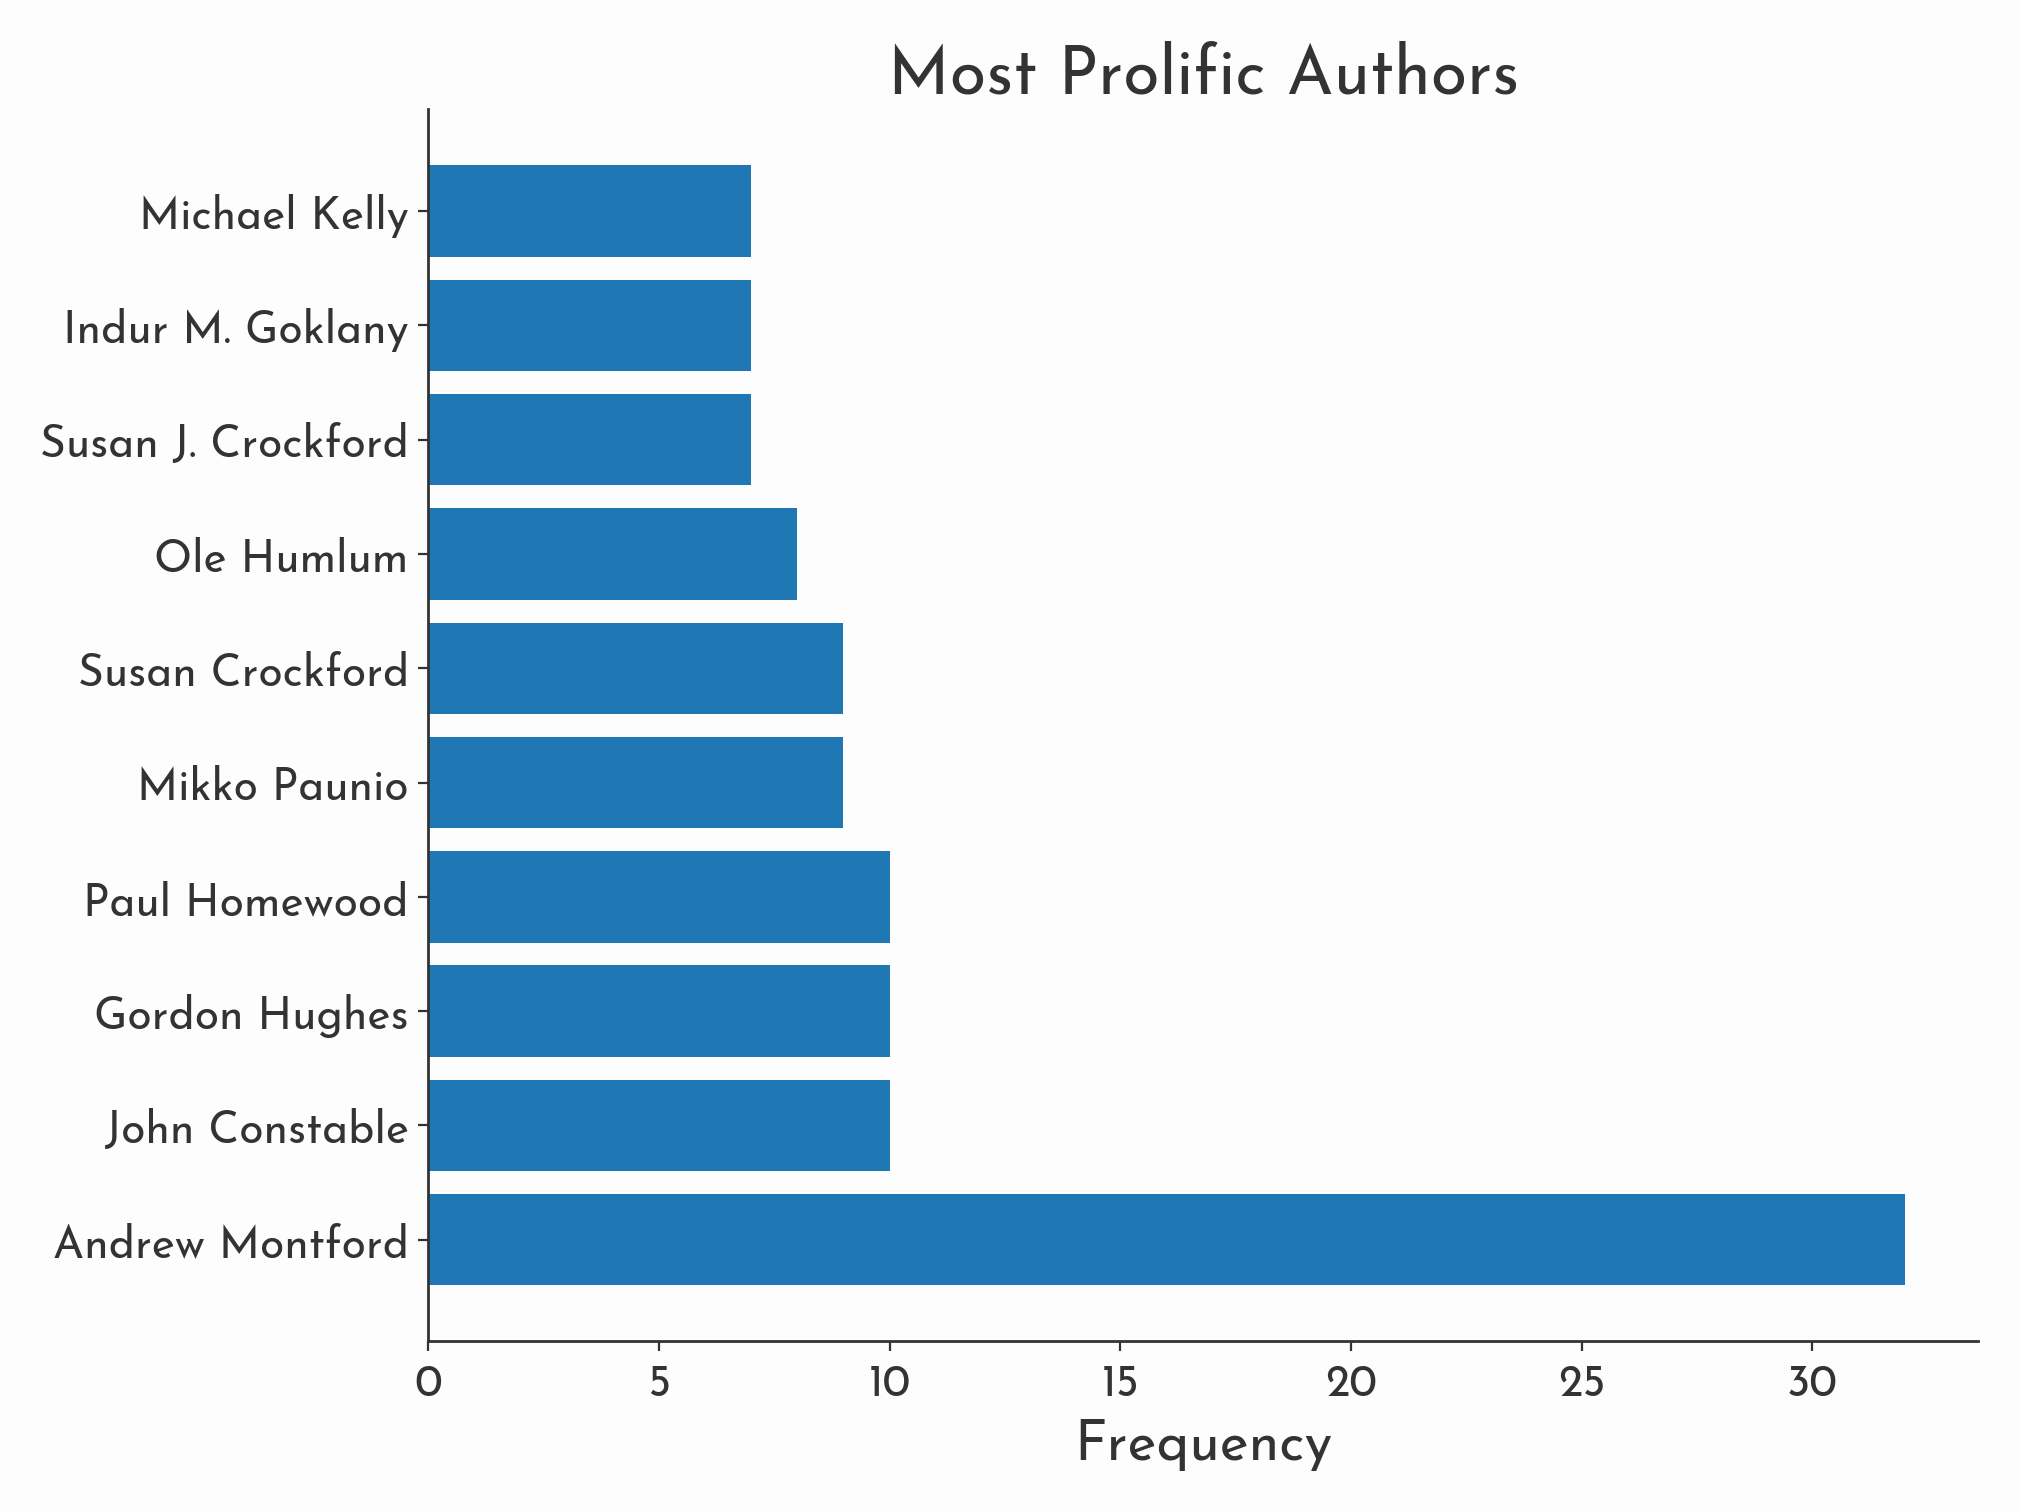

In [ ]:
top_10_authors = author_frequency.most_common(10)

# Separating items and their frequencies
items, frequencies = zip(*top_10_authors)

# Creating a horizontal bar chart
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.barh(items, frequencies)
plt.xlabel('Frequency')
plt.title('Most Prolific Authors')
plt.savefig(f'{plots_dir}/author_frequency.png')
plt.show()

## Organisation Frequency

Lets see the most common organisations to author publications:

In [ ]:
organisations = [item for sublist in org_pubs['organisation'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
organisations = [organisation for organisation in organisations if all(name not in organisation.lower() for name in const.org_names)]

In [ ]:
organisation_frequency = Counter(organisations)

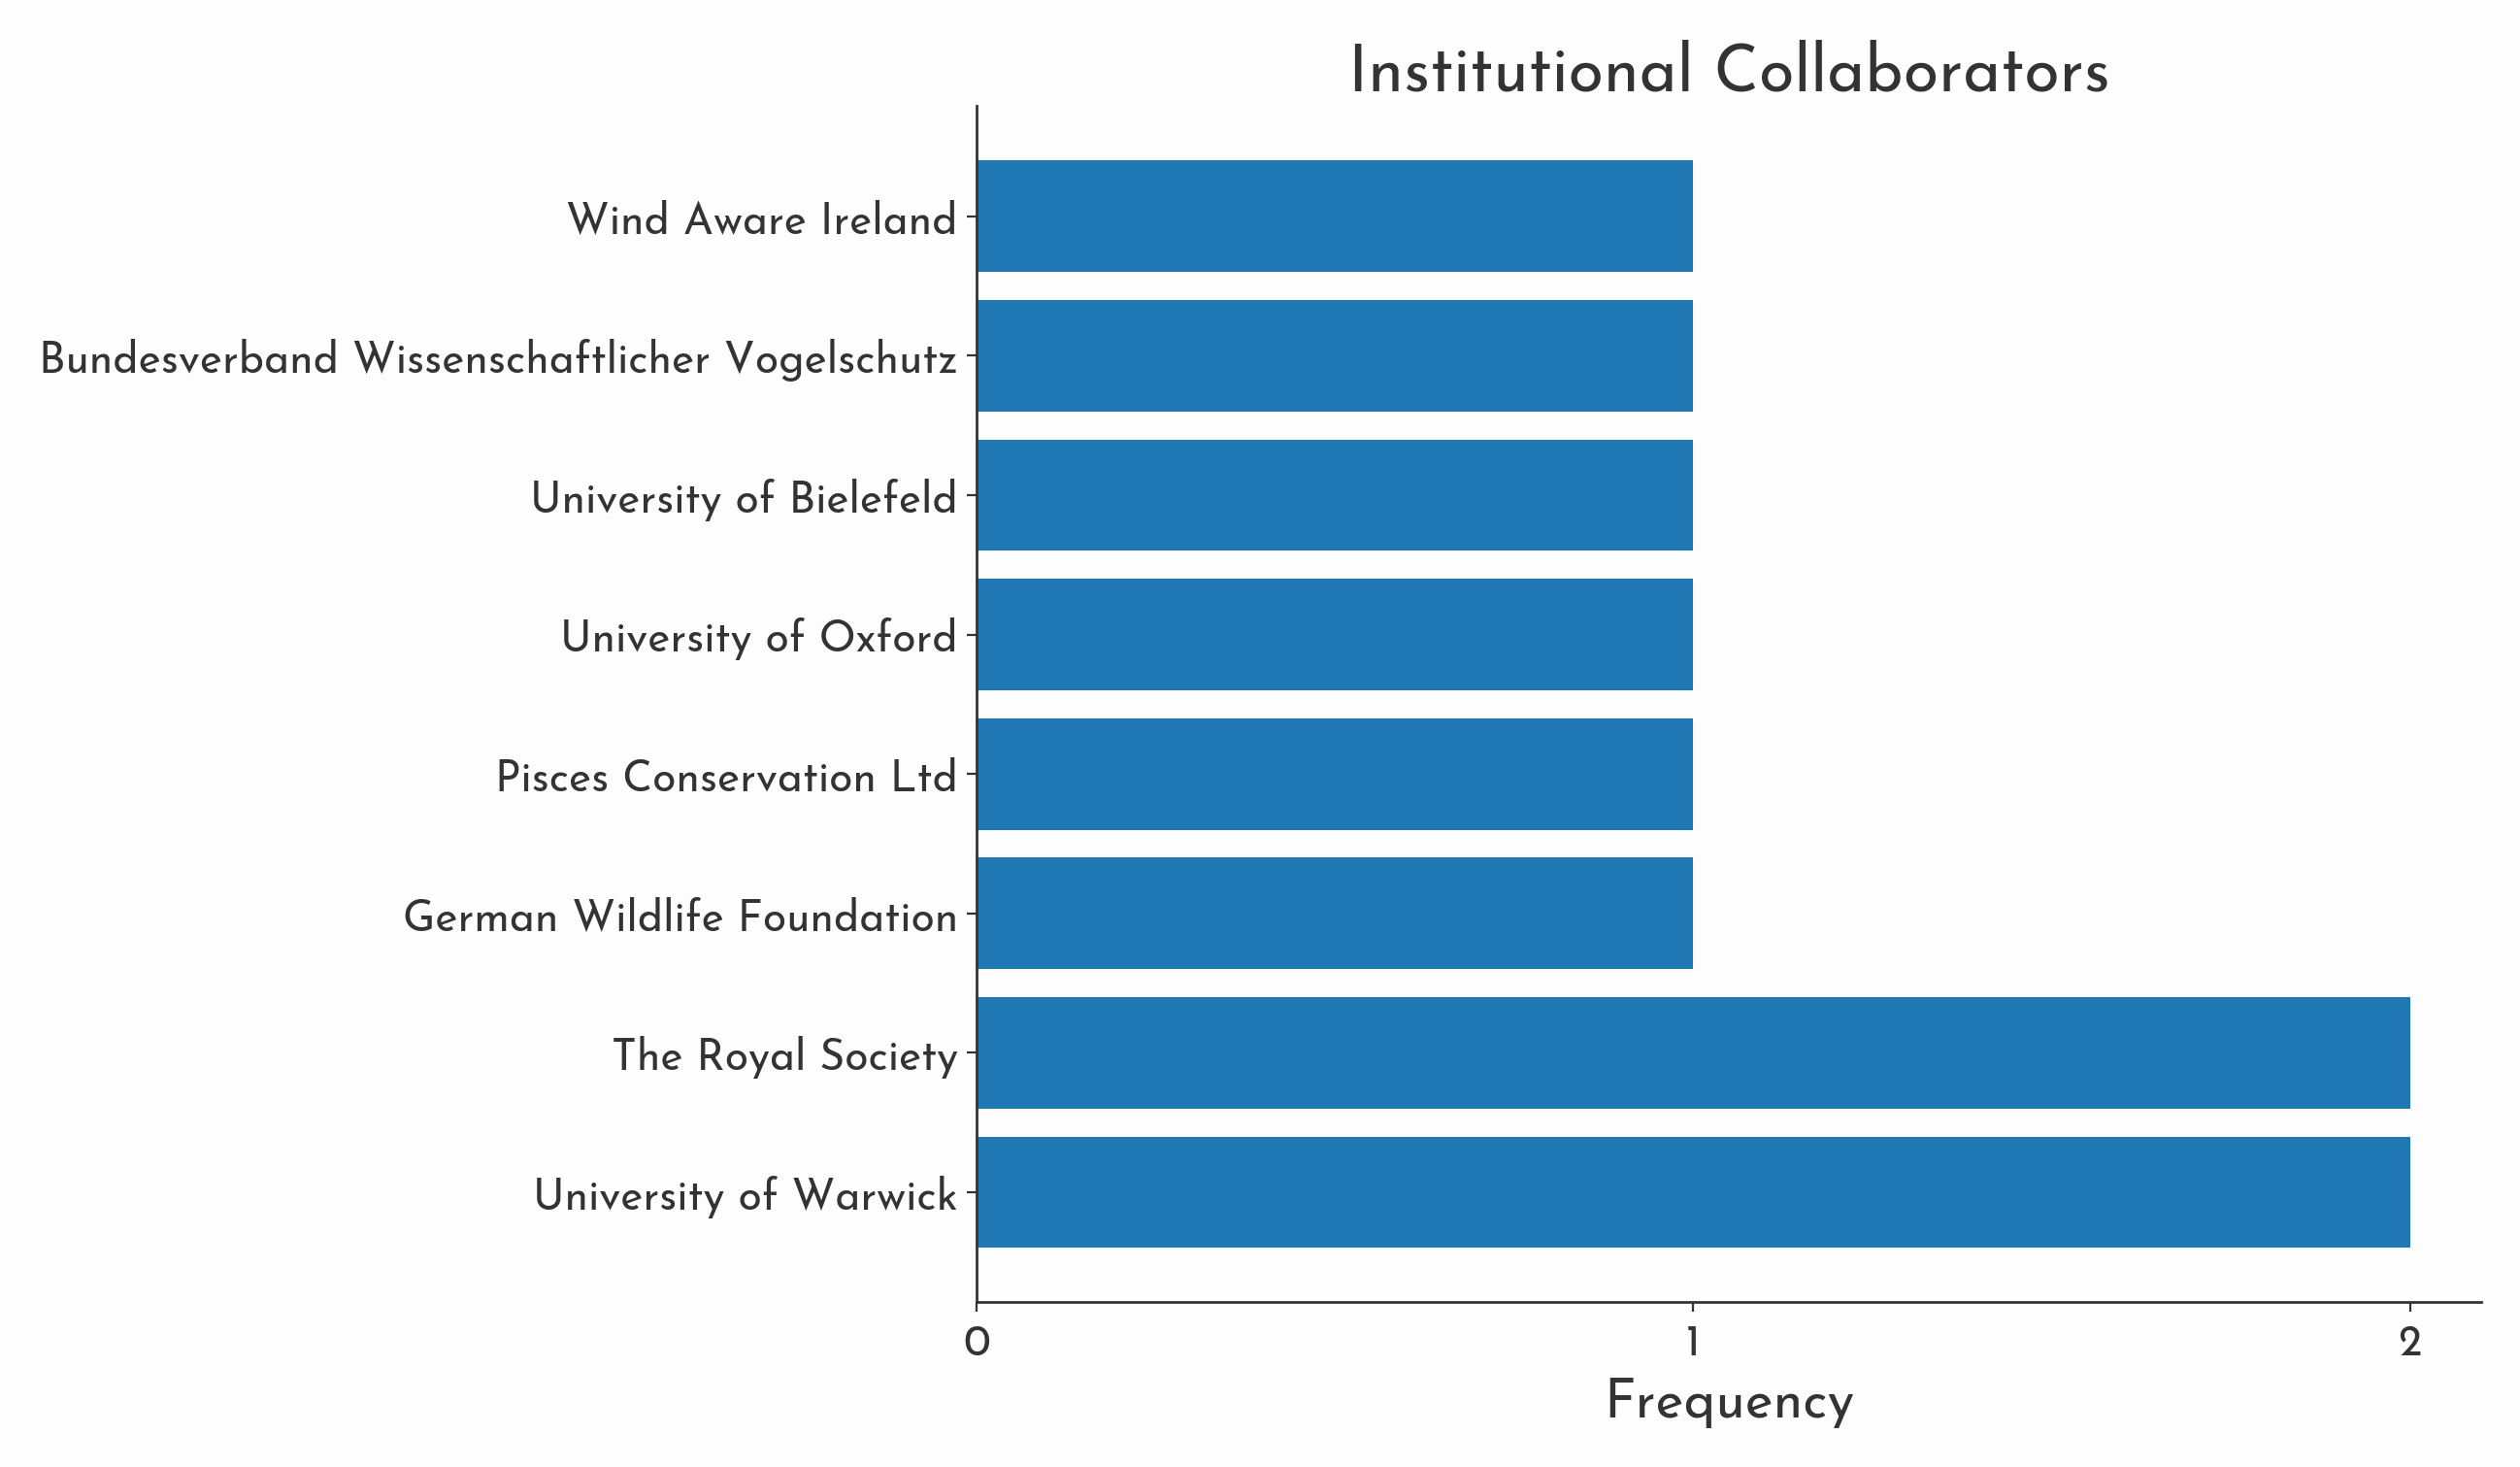

In [ ]:
top_10_orgs = organisation_frequency.most_common(10)

# Separating items and their frequencies
items, frequencies = zip(*top_10_orgs)

# Creating a horizontal bar chart
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.barh(items, frequencies)
plt.xlabel('Frequency')
plt.title('Institutional Collaborators')
# Set x-axis ticks to show only complete numbers
max_frequency = max(frequencies)
step = 1  # Define step size based on your data scale
plt.xticks(range(0, max_frequency + 1, step))
plt.savefig(f'{plots_dir}/organisation_frequency.png')
plt.show()

## Funder Frequency

In [ ]:
funders = [item for sublist in org_pubs['funders'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
funders = [organisation for organisation in funders if all(name not in organisation.lower() for name in const.org_names)]

In [ ]:
funder_frequency = Counter(funders)

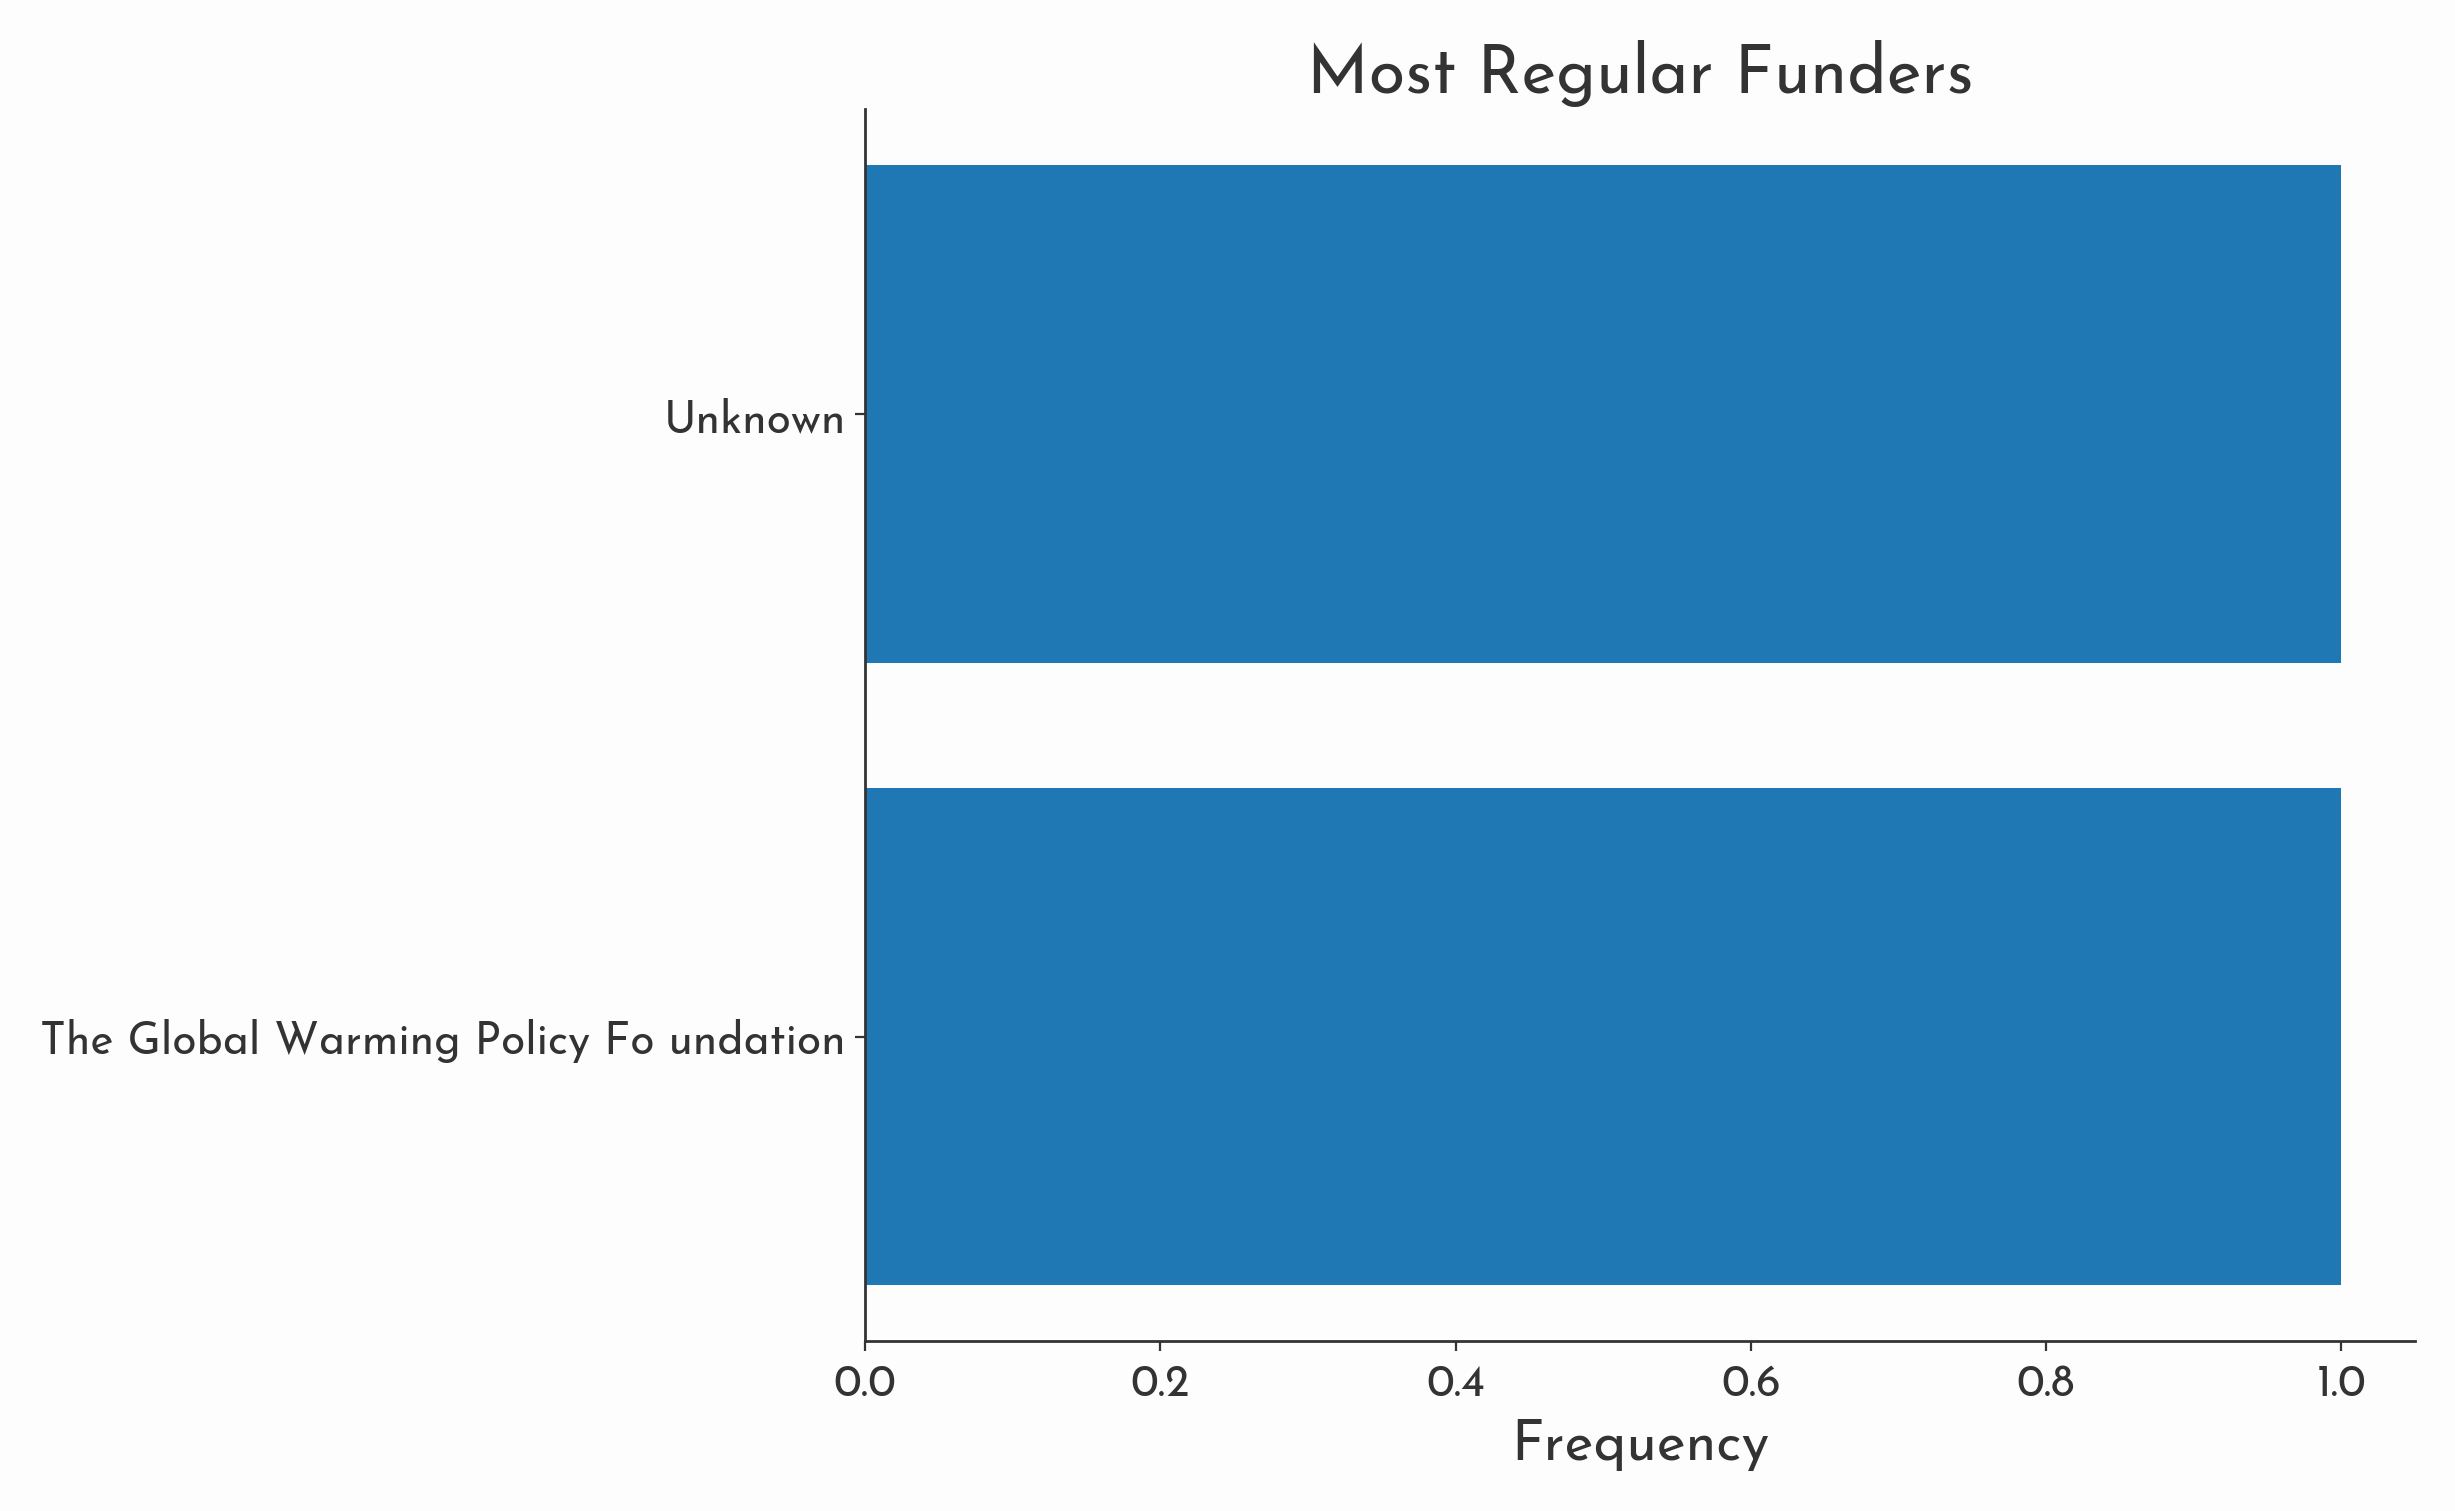

In [ ]:
top_10_funders = funder_frequency.most_common(10)

# Separating items and their frequencies
items, frequencies = zip(*top_10_funders)

# Creating a horizontal bar chart
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.barh(items, frequencies)
plt.xlabel('Frequency')
plt.title('Most Regular Funders')
plt.savefig(f'{plots_dir}/funder_frequency.png')
plt.show()

## Keyword Frequency

In [ ]:
keywords = [item for sublist in org_pubs['keywords'] if isinstance(ast.literal_eval(sublist), list) for item in ast.literal_eval(sublist)]

In [ ]:
keyword_frequency = Counter(keywords)

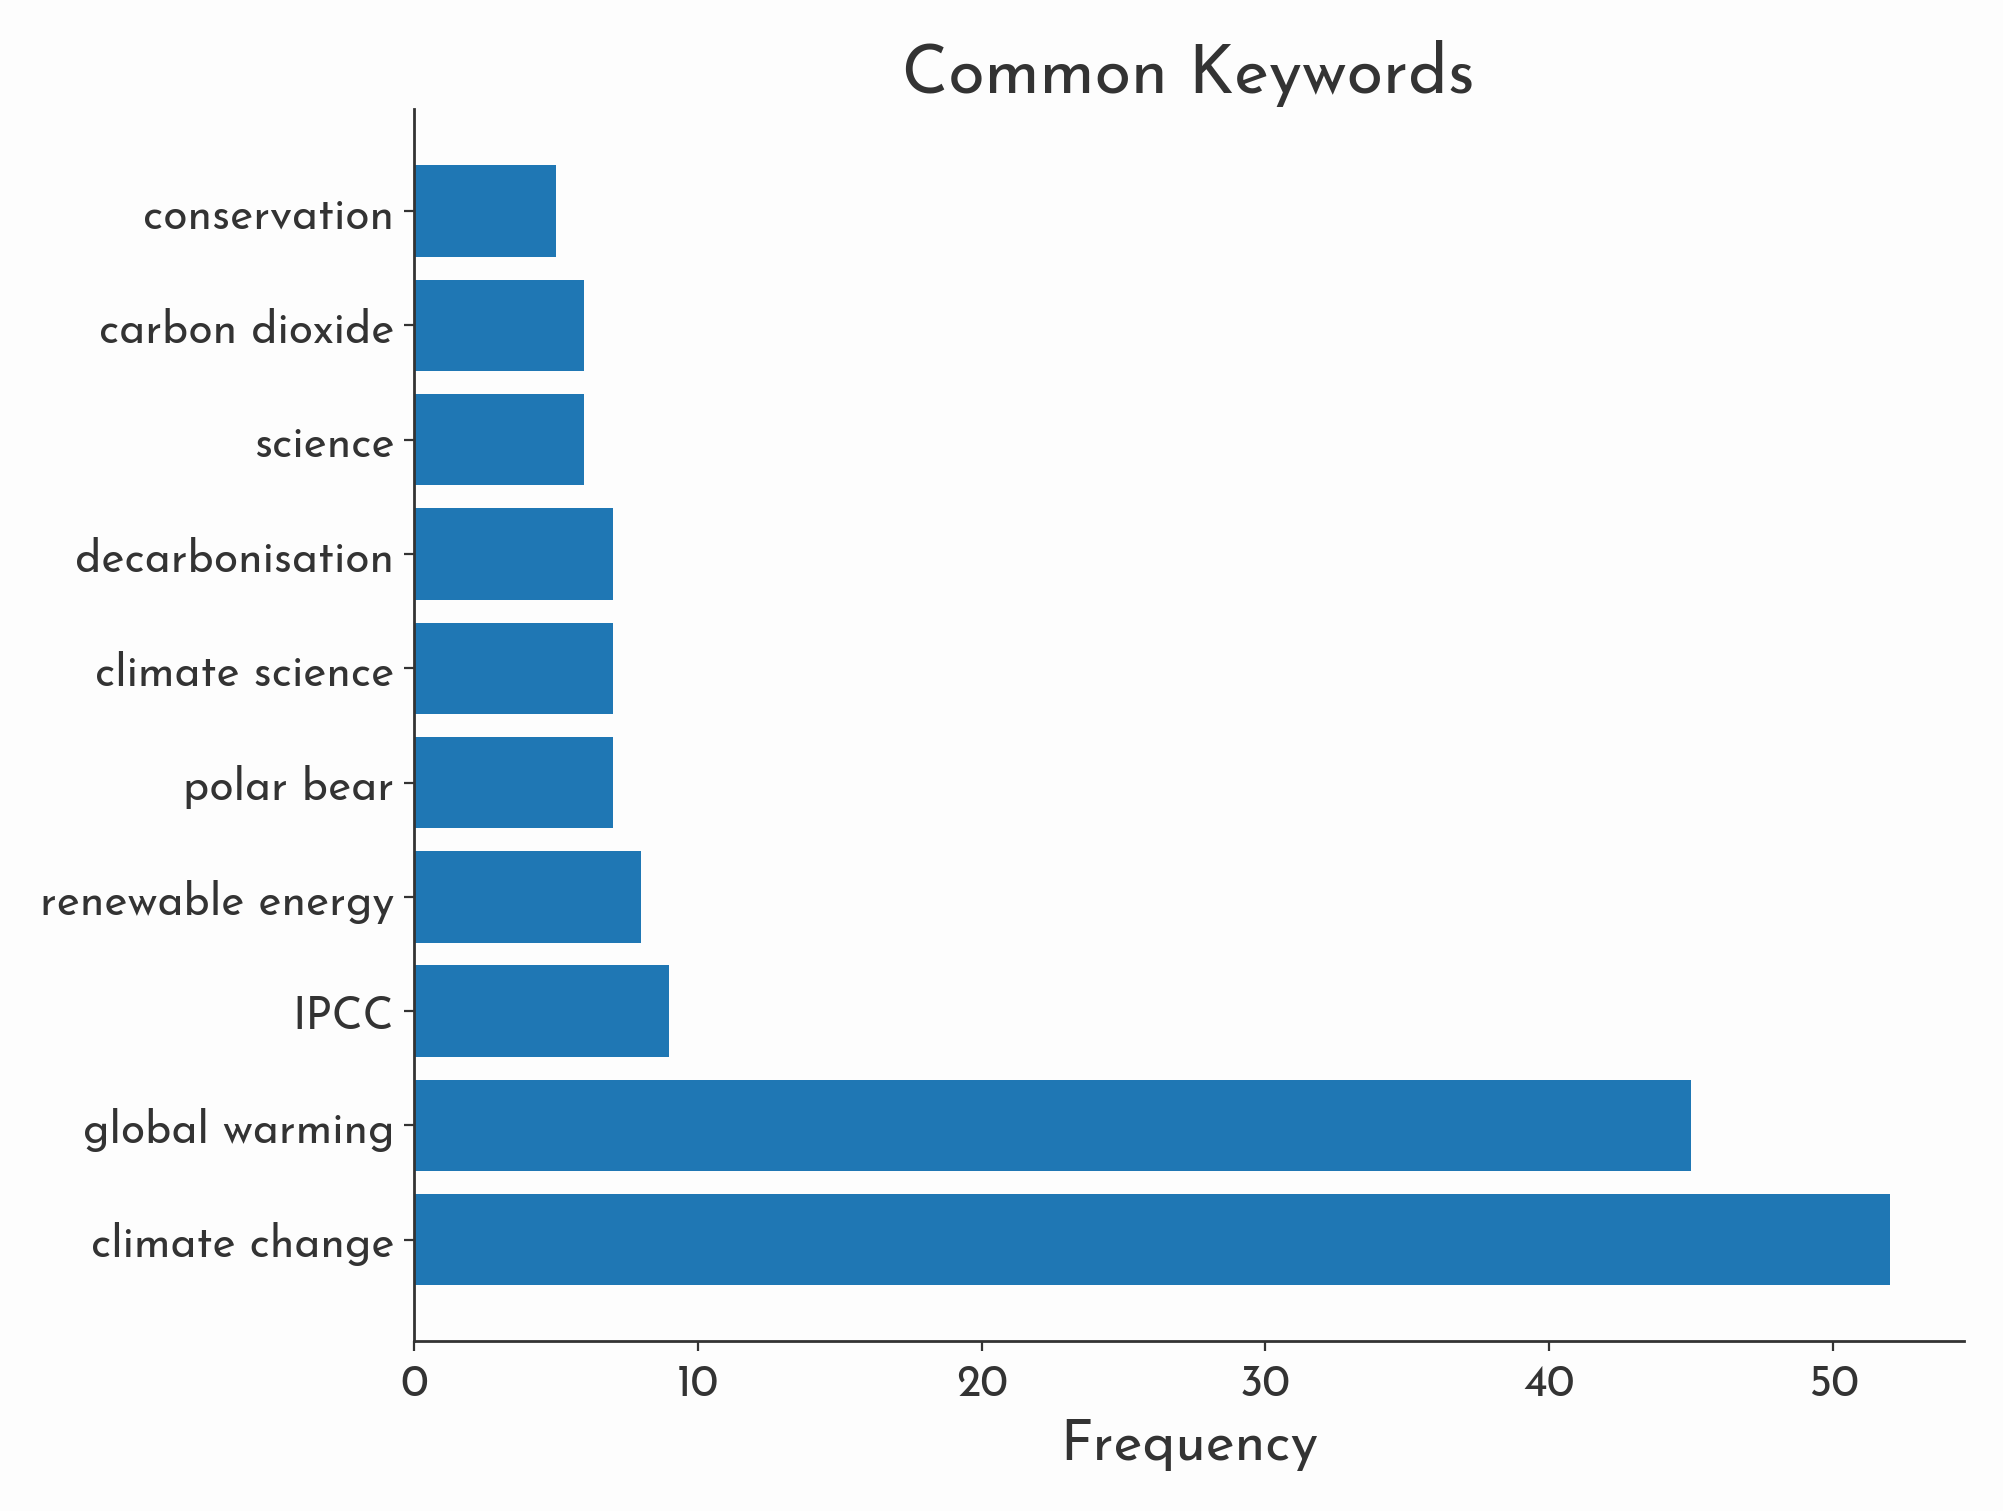

In [ ]:
top_10_keywords = keyword_frequency.most_common(10)

# Separating items and their frequencies
items, frequencies = zip(*top_10_keywords)

# Creating a horizontal bar chart
plt.figure(figsize=(10, 8))  # Adjust size as needed
plt.barh(items, frequencies)
plt.xlabel('Frequency')
plt.title('Common Keywords')
plt.savefig(f'{plots_dir}/keyword_frequency.png')
plt.show()

## Publication Frequency

In [ ]:
def extract_year(text):
    match = re.search(r'\d{4}', text)
    return match.group(0) if match else None

In [ ]:
org_pubs['year'] = org_pubs['date'].apply(lambda x: extract_year(str(x)))

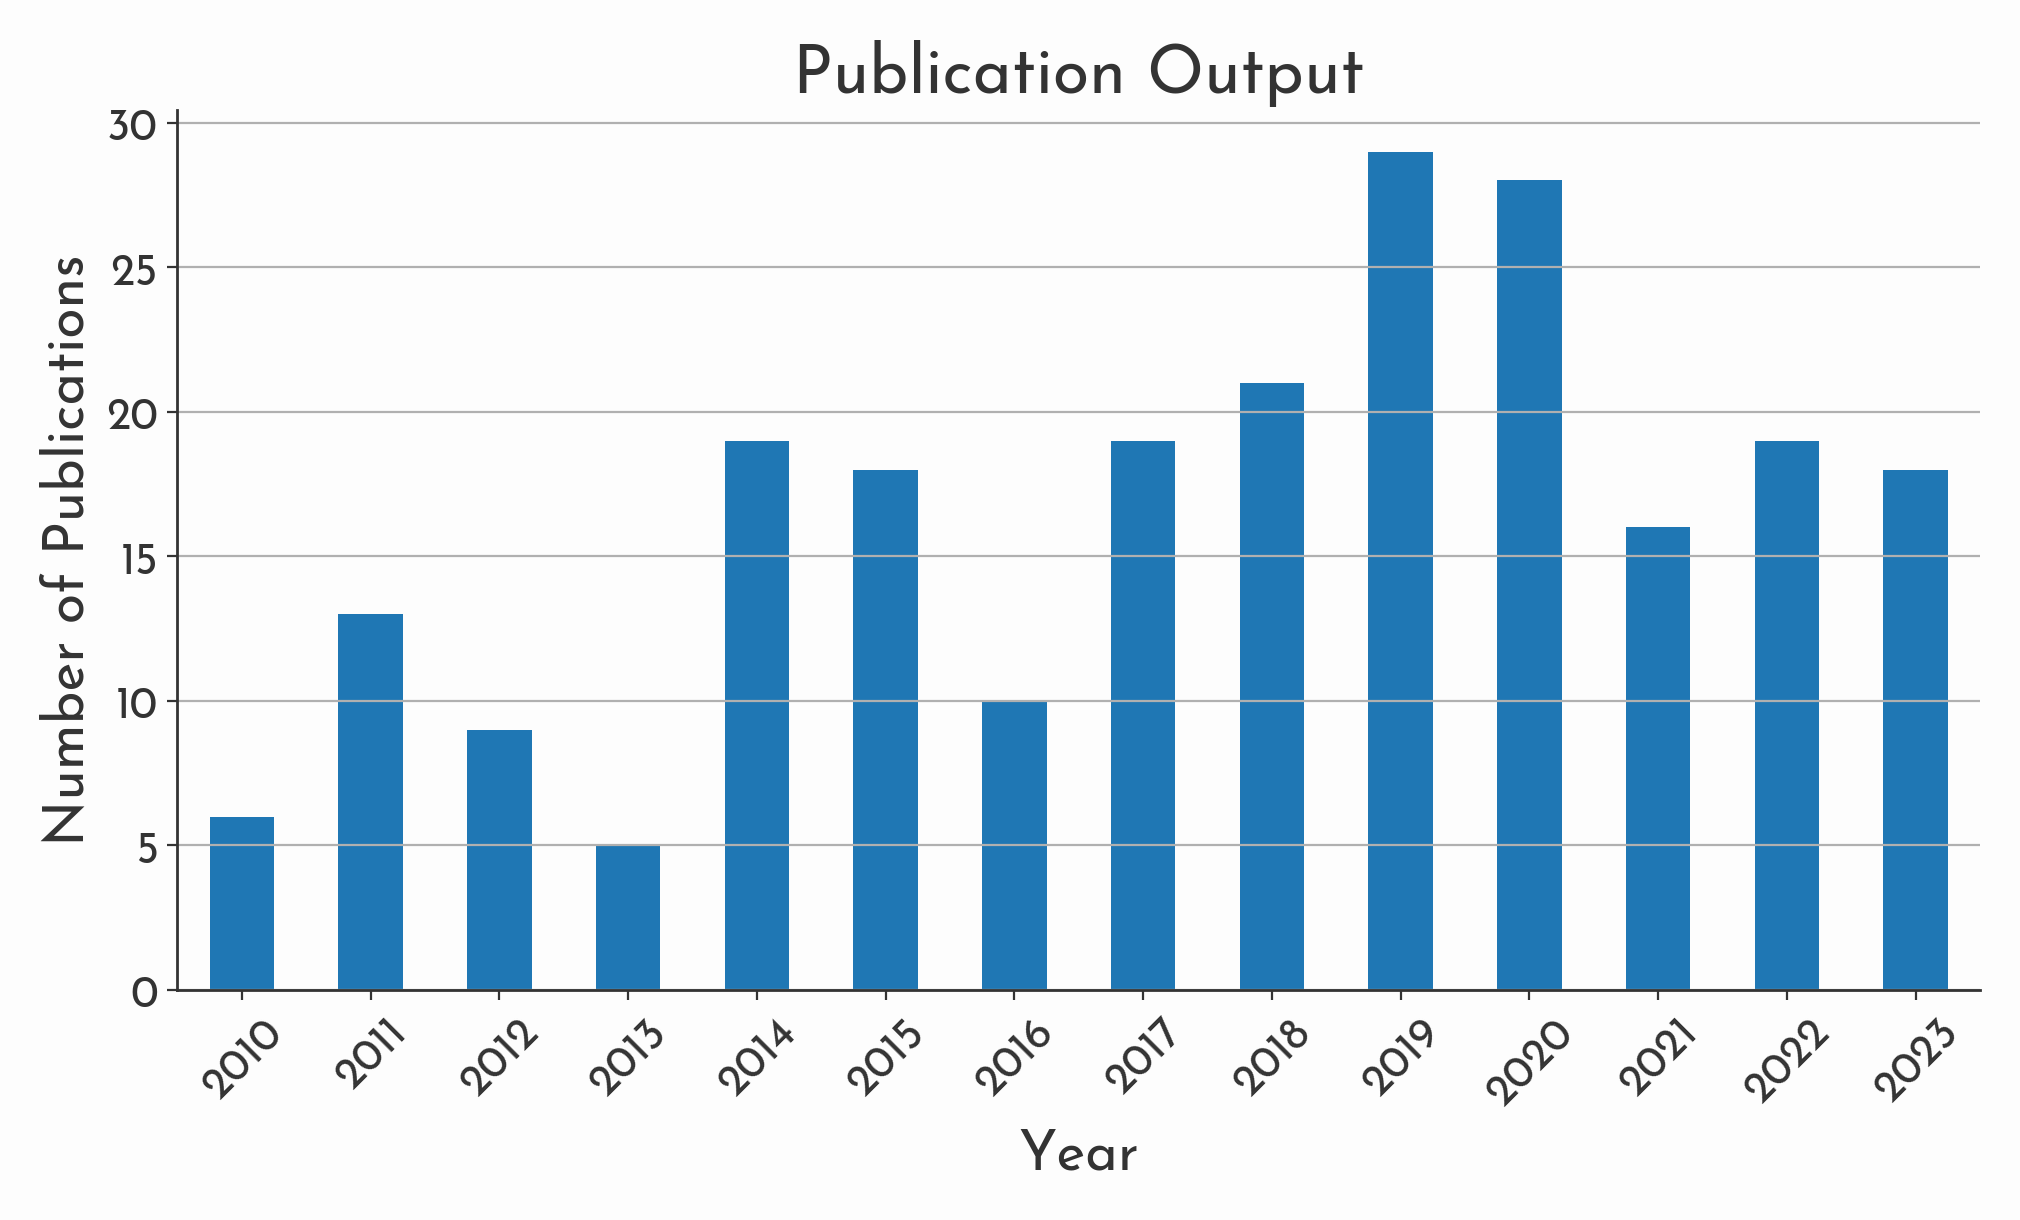

In [ ]:
year_counts = org_pubs['year'].dropna().astype(int).value_counts().sort_index()
# Plotting
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar')
plt.title('Publication Output')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f'{plots_dir}/publication_output.png')
plt.show()

## Co-author Frequency

In [ ]:
author_lists = [ast.literal_eval(sublist) for sublist in org_pubs['authors'] if isinstance(ast.literal_eval(sublist), list)]

In [ ]:
G = nx.Graph()

for sublist in author_lists:
    for pair in itertools.combinations(sublist, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

net = Network(notebook=True)

for node in G.nodes:
    net.add_node(node, title=node)

for edge in G.edges:
    weight = G[edge[0]][edge[1]]['weight']
    net.add_edge(edge[0], edge[1], value=weight)

# Generate network with specific options
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 25
      }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -100000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.5,
      "avoidOverlap": 0.5
    },
    "minVelocity": 0.75
  }
}
""")

# Show the network
net.show(f"{const.pre_output_path}/plots/coauthor_network.html")

/Users/seangreaves/adu_dev/pubcrawler/pubcrawler/store/pre_output/plots/coauthor_network.html


## Institutional Collaborations

In [ ]:
organisation_lists = [ast.literal_eval(sublist) for sublist in org_pubs['organisation'] if isinstance(ast.literal_eval(sublist), list)]

In [ ]:
G = nx.Graph()

for sublist in organisation_lists:
    for pair in itertools.combinations(sublist, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)

net = Network(notebook=True)

for node in G.nodes:
    net.add_node(node, title=node)

for edge in G.edges:
    weight = G[edge[0]][edge[1]]['weight']
    net.add_edge(edge[0], edge[1], value=weight)

# Generate network with specific options
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 25
      }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -100000,
      "centralGravity": 0.3,
      "springLength": 100,
      "springConstant": 0.04,
      "damping": 0.5,
      "avoidOverlap": 0.5
    },
    "minVelocity": 0.75
  }
}
""")

# Show the network
net.show(f"{const.pre_output_path}/plots/org_network.html")

/Users/seangreaves/adu_dev/pubcrawler/pubcrawler/store/pre_output/plots/org_network.html


Export all data to zip:

In [ ]:
if shutil.make_archive(f'{const.data_path}/{const.directory_name}', 'zip', f'{const.pre_output_path}'):
    print(f"All files saved to {const.data_path}/{const.directory_name}")